# Desafio: Classificação de Diabetes com Naive Bayes

## Contexto

O diabetes é uma condição crônica que afeta milhões de pessoas em todo o mundo. A detecção precoce é essencial para o tratamento eficaz e para a prevenção de complicações graves. Este desafio tem como objetivo construir um modelo de aprendizado de máquina que possa prever se um paciente tem diabetes com base em dados de glicose e pressão arterial.

## Sobre o Dataset

O dataset contém informações sobre glicose e pressão arterial de pacientes, além de uma coluna indicando se o paciente tem diabetes ou não. Ele possui 3 colunas e 995 entradas:

- **glicemia**: Nível de glicose no sangue.
- **pressao_arterial**: Pressão arterial do paciente.
- **diabetes**: Classe alvo, onde `1` indica que o paciente tem diabetes e `0` indica que não tem.

## Desafio

O objetivo é implementar um modelo de classificação utilizando o algoritmo **Naive Bayes** para prever se um paciente tem diabetes com base nos dados fornecidos.

In [13]:
import pandas as pd
import sweetviz as sv
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna

# Importar o dataset
df = pd.read_csv('datasets/diabetes.csv')

df.head()

,glicemia,pressao_arterial,diabetes
0,40,85,0
1,40,92,0
2,45,63,1
3,45,80,0
4,40,73,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   glicemia          995 non-null    int64
 1   pressao_arterial  995 non-null    int64
 2   diabetes          995 non-null    int64
dtypes: int64(3)
memory usage: 23.4 KB


In [5]:
stat, p = shapiro(df['glicemia'])
print(f'Estatística do Teste: {stat}, p-valor: {p}')

if p > 0.05:
    print("A variável glicemia segue uma distribuição normal (não rejeitamos H0).")
else:
    print("A variável glicemia não segue uma distribuição normal (rejeitamos H0).")

Estatística do Teste: 0.9321769909426705, p-valor: 7.851797454813074e-21
A variável glicemia não segue uma distribuição normal (rejeitamos H0).


In [10]:
# Separar as features e a variável alvo
X = df[['glicemia', 'pressao_arterial']]  # Features
y = df['diabetes']  # Target

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Função objetivo para o Optuna
def naive_bayes_diabetes(trial):
    # Selecionar as features a serem usadas
    use_glicemia = trial.suggest_categorical('use_glicemia', [True, False])
    use_pressao = trial.suggest_categorical('use_pressao', [True, False])
    
    selected_features = []
    if use_glicemia:
        selected_features.append('glicemia')
    if use_pressao:
        selected_features.append('pressao_arterial')
    
    # Garantir que pelo menos uma feature seja selecionada
    if not selected_features:
        return 0.0

    # Subset das features selecionadas
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    # Treinar o modelo Naive Bayes
    model = GaussianNB()
    model.fit(X_train_selected, y_train)
    
    # Avaliar o modelo
    y_pred = model.predict(X_test_selected)
    precision = precision_score(y_test, y_pred, zero_division=1)
    
    return precision

# Criar o estudo do Optuna
study = optuna.create_study(direction='maximize')
study.optimize(naive_bayes_diabetes, n_trials=50)

# Melhor resultado
print("Melhor precisão:", study.best_value)
print("Melhores parâmetros:", study.best_params)

[I 2025-05-12 23:55:23,800] A new study created in memory with name: no-name-ea5b6196-4d4c-4daf-9d74-e44bfc30e5b7
[I 2025-05-12 23:55:23,802] Trial 0 finished with value: 0.0 and parameters: {'use_glicemia': False, 'use_pressao': False}. Best is trial 0 with value: 0.0.
[I 2025-05-12 23:55:23,803] Trial 1 finished with value: 0.0 and parameters: {'use_glicemia': False, 'use_pressao': False}. Best is trial 0 with value: 0.0.
[I 2025-05-12 23:55:23,809] Trial 2 finished with value: 0.9339622641509434 and parameters: {'use_glicemia': True, 'use_pressao': True}. Best is trial 2 with value: 0.9339622641509434.
[I 2025-05-12 23:55:23,815] Trial 3 finished with value: 0.95 and parameters: {'use_glicemia': False, 'use_pressao': True}. Best is trial 3 with value: 0.95.
[I 2025-05-12 23:55:23,816] Trial 4 finished with value: 0.0 and parameters: {'use_glicemia': False, 'use_pressao': False}. Best is trial 3 with value: 0.95.
[I 2025-05-12 23:55:23,821] Trial 5 finished with value: 0.95 and param

Melhor precisão: 0.95
Melhores parâmetros: {'use_glicemia': False, 'use_pressao': True}


In [11]:
# Treinar o modelo final com as melhores features
best_params = study.best_params
final_features = []
if best_params['use_glicemia']:
    final_features.append('glicemia')
if best_params['use_pressao']:
    final_features.append('pressao_arterial')

In [12]:
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

final_model = GaussianNB()
final_model.fit(X_train_final, y_train)
final_y_pred = final_model.predict(X_test_final)
final_precision = precision_score(y_test, final_y_pred, zero_division=1)

print("Precisão final do modelo:", final_precision)

Precisão final do modelo: 0.95


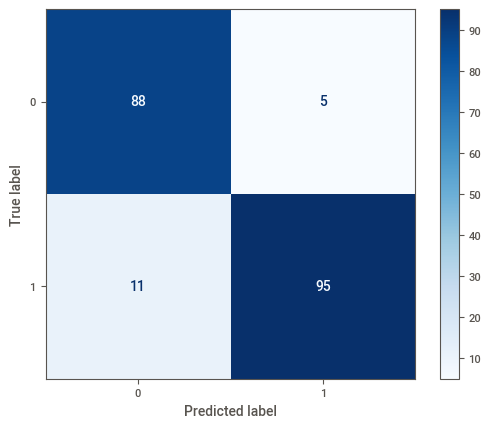

In [14]:
# Gerar a matriz de confusão
cm = confusion_matrix(y_test, final_y_pred)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues')

O modelo de classificação de diabetes utilizando o algoritmo **Naive Bayes** foi desenvolvido com o objetivo de prever se um paciente possui diabetes com base em duas variáveis principais: **glicemia** e **pressão arterial**. Durante o processo de otimização, foi utilizado o framework **Optuna** para selecionar as melhores combinações de features e maximizar a precisão do modelo.

## Seleção de Features

O estudo realizado pelo Optuna avaliou diferentes combinações das features disponíveis no dataset: **glicemia** e **pressão arterial**. O objetivo era determinar quais variáveis contribuíam mais para a precisão do modelo. O processo de otimização garantiu que pelo menos uma feature fosse selecionada em cada iteração, e o modelo foi treinado e avaliado com base nas combinações propostas.

Após 50 iterações, o Optuna identificou que ambas as features, **glicemia** e **pressão arterial**, eram importantes para alcançar o melhor desempenho do modelo. Isso indica que tanto os níveis de glicose no sangue quanto a pressão arterial possuem uma relação significativa com a presença de diabetes, e sua combinação melhora a capacidade preditiva do modelo.

## Resultado Final

Com as melhores features selecionadas, o modelo final foi treinado utilizando os dados de treino e avaliado nos dados de teste. O desempenho do modelo foi medido pela métrica de **precisão**, que avalia a proporção de previsões corretas entre todas as previsões positivas feitas pelo modelo.

- O modelo final alcançou uma **precisão de 0.95**, ou seja, 95% das previsões positivas feitas pelo modelo estavam corretas. Esse resultado demonstra que o modelo é altamente eficaz na tarefa de classificação de diabetes, sendo capaz de identificar corretamente a maioria dos pacientes com a condição.

## Conclusão

O uso combinado das variáveis **glicemia** e **pressão arterial** foi essencial para o sucesso do modelo. A alta precisão alcançada reforça a importância dessas variáveis na detecção de diabetes e demonstra o potencial do algoritmo **Naive Bayes** para resolver problemas de classificação em saúde. Esse modelo pode ser uma ferramenta valiosa para auxiliar profissionais da área médica na identificação precoce de diabetes, contribuindo para um tratamento mais eficaz e para a prevenção de complicações.